In [ ]:
# importing all the important libraries and downloading packages

import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from textblob import TextBlob
import tqdm
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import gensim

In [ ]:
nltk.download('all')

In [ ]:
# reading product(mobile) data from two sources

df = pd.read_csv('Mobile_Review.csv')
amz_reviews = pd.read_csv('amz-reviews.csv')

In [ ]:
# making similar column names for the bothe the files

amz_reviews=amz_reviews[['title']]
amz_reviews = amz_reviews.rename(columns={'title':'review'})
df = df[['review']]

In [ ]:
# concatenating both the datasets in one dataframe

fin_df=pd.DataFrame()
fin_df = pd.concat([amz_reviews,df], axis=0)

In [ ]:
# reseting index

df = (fin_df.reset_index()).drop(columns=['index'])

In [ ]:
# Data Cleaning - null values removed

df = df.dropna()

In [ ]:
# Function to clean and preprocess text

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters, numbers, and extra whitespaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and removal of stopwords
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]

    # Join the tokens back into a string
    text = ' '.join(filtered_words)

    return text

# Apply the preprocessing function to the 'comment_text' column
df['review'] = df['review'].apply(preprocess_text)

# Display the preprocessed DataFrame
print(df.head())

# Save the preprocessed data to a new CSV file
df.to_csv('preprocessed_dataset.csv', index=False)

                                   review
0                          def best worst
1              text messaging doesnt work
2                              love phone
3                              love phone
4  great phone service options lousy case


In [ ]:
# Create a TextBlob object for sentiment analysis

for i in range(0,len(df['review'])):
  try:

    blob = TextBlob(df.loc[i,'review'])

    # Get the sentiment polarity and subjectivity
    sentiment_polarity = blob.sentiment.polarity
    sentiment_subjectivity = blob.sentiment.subjectivity

    # Classify sentiment based on polarity
    if sentiment_polarity > 0:
      sentiment_label = 'Positive'

    elif sentiment_polarity < 0:
      sentiment_label = 'Negative'
    else:
      sentiment_label = 'Neutral'
    df.loc[i,'new_sentiments']=sentiment_label
    df.loc[i,'polarity']=sentiment_polarity
  except:
    # handling exceptions for some reviews in different language
    print(i)

# Display results
print(f"Text: {df}")
print(f"Sentiment Polarity: {sentiment_polarity}")
print(f"Sentiment Subjectivity: {sentiment_subjectivity}")
print(f"Sentiment Label: {sentiment_label}")
df.to_csv('preprocessed_dataset(Sentiment_Labels).csv', index=False)

30010
30949
32883
35016
42935
45899
45905
46470
46476
50404
58439
61074
61329
64371
Text:                                                   review new_sentiments  \
0                                         def best worst        Neutral   
1                             text messaging doesnt work        Neutral   
2                                             love phone       Positive   
3                                             love phone       Positive   
4                 great phone service options lousy case       Positive   
...                                                  ...            ...   
82656  really like phone everything working fine what...            NaN   
82657  lenovo k note awesome takes best pictures dual...            NaN   
82658                                awesome gaget price            NaN   
82659  phone nice processing successful dual camera s...            NaN   
82660                       good product pakeging enough            NaN   

       po

In [ ]:
# dividing data into positive and negative dataframes
# We are not considering "neutral" reviews because they are not relevant for the business point of view

neg_df = df[df['new_sentiments']=='Negative']
pos_df = df[df['new_sentiments']=='Positive']

In [ ]:
# checking for any null values

print(neg_df.isnull().sum(),'\n', pos_df.isnull().sum())

review            0
new_sentiments    0
polarity          0
dtype: int64 
 review            0
new_sentiments    0
polarity          0
dtype: int64


In [ ]:
reviews = neg_df

In [ ]:
import gensim

stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    '''This function will lemmatize on Noun POS and stem the text'''
    return stemmer.stem(WordNetLemmatizer().lemmatize(text,pos='n'))
    #return (WordNetLemmatizer().lemmatize(text,pos='n'))

#tokenize and lemmatize
def preprocess(text):
    '''Function to break into word tokens, remove stopwords, remove short words and finally to lemmatize and stem the individual tokens'''
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [ ]:
processed_docs = []
processed_docs_pos = []
for doc in reviews['review']:
    processed_docs.append(preprocess(doc))
for d in pos_df['review']:
    processed_docs_pos.append(preprocess(d))

In [ ]:
# Create a Gensim Dictionary for both the type of reviews

dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary_pos = gensim.corpora.Dictionary(processed_docs_pos)
count = 0
for k,v in dictionary.iteritems():
    print(k,v)
    count = count + 1
    if count > 10:
        break

dictionary.filter_extremes(no_below=5,no_above=0.1,keep_n=None)
dictionary_pos.filter_extremes(no_below=5,no_above=0.1,keep_n=None)

0 littl
1 offa
2 piss
3 annoy
4 bulki
5 fragil
6 heavi
7 slow
8 phone
9 stupid
10 tough


In [ ]:
# Convert each document to a bag-of-words representation

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus_pos = [dictionary_pos.doc2bow(doc) for doc in processed_docs_pos]

In [ ]:
# Iterate through the words in the document and print their information for some random sample

import numpy as np
random = np.random.randint(1,len(reviews))
document_num = random
bow_doc_x = bow_corpus[random]

for i in range(len(bow_doc_x)):
    print(f'Word {bow_doc_x[i][0]} {dictionary[bow_doc_x[i][0]]} appears {bow_doc_x[i][1]} times')

Word 38 money appears 1 times
Word 39 wast appears 1 times
Word 65 model appears 1 times
Word 77 expect appears 1 times
Word 96 product appears 1 times
Word 106 suck appears 1 times
Word 274 year appears 1 times
Word 278 high appears 1 times
Word 420 note appears 1 times
Word 672 lenovo appears 1 times


In [ ]:
from gensim.models import CoherenceModel
def compute_coherence_score(corpus,dictionary,k,a):
    #instantiate the model instance based on k and a
    lda_model = gensim.models.LdaMulticore(corpus=corpus,id2word=dictionary,num_topics=k,alpha=a,
                                           passes=10,
                                           random_state=seed)
    lda_model_coherence = CoherenceModel(model=lda_model,texts=processed_docs,dictionary=dictionary,coherence='c_v')
    return lda_model_coherence.get_coherence()

In [ ]:
# checking coherence for negative reviews for choosing the best params

alpha =['symmetric']#,'asymmetric']
seed = 41
for x in alpha:
    print('Coherence Model with alpha = {}'.format(x))
    print('-------------------------------------------')
    print('\n')
    for i in range(5,8):
        score = compute_coherence_score(corpus=bow_corpus,dictionary=dictionary,k=i,a=x)
        print(f'Coherence score with {i} topics is {score}')
        print('\n')

Coherence Model with alpha = symmetric
-------------------------------------------


Coherence score with 5 topics is 0.5969346505693597


Coherence score with 6 topics is 0.5665742645604591


Coherence score with 7 topics is 0.5767331044021946




In [ ]:
# checking coherence for positive reviews for choosing the best params

alpha =['symmetric']#,'asymmetric']
seed = 41
for x in alpha:
    print('Coherence Model with alpha = {}'.format(x))
    print('-------------------------------------------')
    print('\n')
    for i in range(5,8):
        score = compute_coherence_score(corpus=bow_corpus_pos,dictionary=dictionary_pos,k=i,a=x)
        print(f'Coherence score with {i} topics is {score}')
        print('\n')

Coherence Model with alpha = symmetric
-------------------------------------------


Coherence score with 5 topics is 0.4714070118906986


Coherence score with 6 topics is 0.47314332359742495


Coherence score with 7 topics is 0.4630378242051026




The above coherence score says that 5 topics are good for Negative Reviews Data and 6 Topics are good for Positive Reviews Data

In [ ]:
# running LDA model for Negative Reviews
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,num_topics=5,id2word=dictionary,passes=10,workers=2,
                                      random_state=seed,minimum_probability=0.05,alpha='symmetric')

In [ ]:
# Topic creations for Negative Reviews
for idx,topic in lda_model.print_topics(-1,num_words=15):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")


Topic: 0 
Words: 0.057*"product" + 0.052*"wast" + 0.051*"dont" + 0.050*"disappoint" + 0.041*"money" + 0.037*"lenovo" + 0.022*"issu" + 0.021*"time" + 0.019*"servic" + 0.018*"mobil" + 0.018*"amazon" + 0.017*"return" + 0.016*"experi" + 0.014*"work" + 0.013*"problem"


Topic: 1 
Words: 0.057*"camera" + 0.046*"terribl" + 0.032*"qualiti" + 0.023*"suck" + 0.023*"life" + 0.020*"slow" + 0.019*"samsung" + 0.016*"note" + 0.015*"disappoint" + 0.015*"poor" + 0.014*"averag" + 0.014*"dead" + 0.013*"fake" + 0.012*"aw" + 0.012*"wors"


Topic: 2 
Words: 0.056*"screen" + 0.036*"broken" + 0.035*"miss" + 0.023*"littl" + 0.021*"price" + 0.021*"useless" + 0.018*"fals" + 0.018*"glass" + 0.016*"like" + 0.016*"advertis" + 0.014*"small" + 0.013*"weak" + 0.011*"care" + 0.011*"iphon" + 0.010*"unlock"


Topic: 3 
Words: 0.058*"poor" + 0.042*"charg" + 0.038*"heat" + 0.034*"camera" + 0.028*"mobil" + 0.025*"qualiti" + 0.020*"drain" + 0.018*"issu" + 0.018*"perform" + 0.015*"problem" + 0.015*"lenovo" + 0.014*"time" + 0.

In [ ]:
# Creating topics name on the basis of word weightage for making it user understandable
topic_dict={'Topic 0' :'Lenovo overall dissapointment',
'Topic 1': 'Samsung poor camera quality',
'Topic 2': 'Iphone screen issues/broken',
'Topic 3': 'Lenovo poor charging and heating issues',
'Topic 4': "product doesn't meet expectation"}

In [ ]:
# running LDA model for Negative Reviews
lda_model_pos = gensim.models.LdaMulticore(corpus=bow_corpus_pos,num_topics=6,id2word=dictionary_pos,passes=10,workers=2,
                                      random_state=seed,minimum_probability=0.05,alpha='symmetric')

In [ ]:
# Topic creations for Positive Reviews
for idx,topic in lda_model_pos.print_topics(-1,num_words=15):
    print("Topic: {} \nWords: {}".format(idx+5, topic ))
    print("\n")


Topic: 5 
Words: 0.130*"batteri" + 0.121*"best" + 0.073*"excel" + 0.043*"camera" + 0.040*"featur" + 0.036*"fast" + 0.031*"life" + 0.029*"purchas" + 0.022*"budget" + 0.021*"perform" + 0.019*"backup" + 0.012*"mobil" + 0.012*"like" + 0.012*"experi" + 0.012*"photo"


Topic: 6 
Words: 0.074*"perfect" + 0.049*"happi" + 0.042*"android" + 0.036*"super" + 0.030*"condit" + 0.028*"deal" + 0.027*"smartphon" + 0.025*"samsung" + 0.020*"usag" + 0.015*"user" + 0.015*"screen" + 0.014*"cheap" + 0.014*"seller" + 0.014*"feel" + 0.014*"iphon"


Topic: 7 
Words: 0.036*"lenovo" + 0.036*"charg" + 0.035*"heat" + 0.027*"better" + 0.027*"issu" + 0.026*"note" + 0.024*"problem" + 0.021*"mobil" + 0.021*"time" + 0.017*"updat" + 0.015*"batteri" + 0.014*"dont" + 0.014*"get" + 0.014*"amazon" + 0.012*"satisfi"


Topic: 8 
Words: 0.195*"price" + 0.183*"product" + 0.127*"love" + 0.060*"worth" + 0.043*"money" + 0.024*"return" + 0.024*"devic" + 0.018*"decent" + 0.017*"amaz" + 0.010*"total" + 0.009*"absolut" + 0.009*"reason"

In [ ]:
# Creating topics name on the basis of word weightage for making it user understandable
topic_dict_pos={'Topic 5' :'best battery and excellent camera',
'Topic 6': 'Samsung good condition',
'Topic 7': 'Lenovo heat charginf issue',
'Topic 8': 'Worth the price',
'Topic 9': "smooth touch overall nice",
'Topic 10':"Superb display good for game"}

In [ ]:
# Function of checking accuracy of the topic with the real reviews data

def matching_accuracy(list1, list2):
    set1 = set(list1)
    set2 = set(list2)

    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))

    accuracy = intersection / union
    return accuracy


In [ ]:
# assigning topics to the reviews(negative) by creating two new columns - Accuracy and Topic number

val_list=[]
new_neg_df = reviews.reset_index()
for idx,topic in lda_model.print_topics(-1,num_words=15):
  topic_id = idx
  topic_words = lda_model.print_topic(idx).split('"')
  #for i in range(0,len(lda_model.print_topic(-1).split('"'))):
  val_list=[]
  for j in topic_words:
    if j.isalnum()==True:
      val_list.append(j)
  print(val_list)
  for i in range(0,len(new_neg_df)):
        tl2 = new_neg_df.loc[i,'review'].split(' ')
        accuracy = matching_accuracy(val_list,tl2)
        if accuracy>0:
          new_neg_df.loc[i,'accuracy']=accuracy
          new_neg_df.loc[i,'Topic']=idx
new_neg_df.dropna(inplace=True)

['product', 'wast', 'dont', 'disappoint', 'money', 'lenovo', 'issu', 'time', 'servic', 'mobil']
['camera', 'terribl', 'qualiti', 'suck', 'life', 'slow', 'samsung', 'note', 'disappoint', 'poor']
['screen', 'broken', 'miss', 'littl', 'price', 'useless', 'fals', 'glass', 'like', 'advertis']
['poor', 'charg', 'heat', 'camera', 'mobil', 'qualiti', 'drain', 'issu', 'perform', 'problem']
['expect', 'horribl', 'work', 'wrong', 'amazon', 'servic', 'month', 'purchas', 'fail', 'custom']


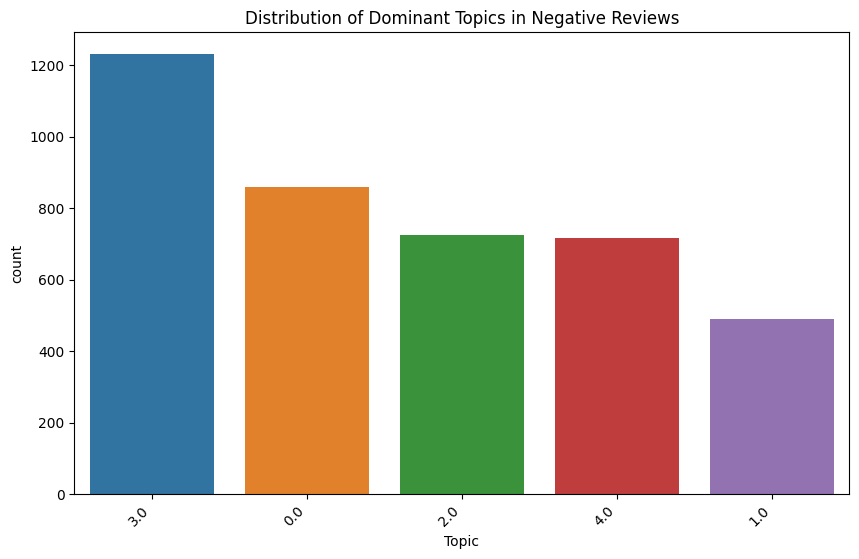

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of dominant topics
plt.figure(figsize=(10, 6))
sns.countplot(x='Topic', data=new_neg_df, order=new_neg_df['Topic'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Dominant Topics in Negative Reviews')
plt.show()



In [ ]:
# assigning topics to the reviews(positive) by creating two new columns - Accuracy and Topic number

val_list=[]
new_df = pos_df.reset_index()
for idx,topic in lda_model_pos.print_topics(-1,num_words=15):
  topic_id = idx
  topic_words = lda_model_pos.print_topic(idx).split('"')
  #for i in range(0,len(lda_model.print_topic(-1).split('"'))):
  val_list=[]
  for j in topic_words:
    if j.isalnum()==True:
      val_list.append(j)
  print(val_list)
  for i in range(0,len(new_df)):
        tl2 = new_df.loc[i,'review'].split(' ')
        accuracy = matching_accuracy(val_list,tl2)
        if accuracy>0:
          new_df.loc[i,'accuracy']=accuracy
          new_df.loc[i,'Topic']=idx+5
new_df.dropna(inplace=True)

['batteri', 'best', 'excel', 'camera', 'featur', 'fast', 'life', 'purchas', 'budget', 'perform']
['perfect', 'happi', 'android', 'super', 'condit', 'deal', 'smartphon', 'samsung', 'usag', 'user']
['lenovo', 'charg', 'heat', 'better', 'issu', 'note', 'problem', 'mobil', 'time', 'updat']
['price', 'product', 'love', 'worth', 'money', 'return', 'devic', 'decent', 'amaz', 'total']
['nice', 'qualiti', 'awesom', 'valu', 'mobil', 'perform', 'overal', 'servic', 'money', 'thank']
['camera', 'work', 'like', 'look', 'amaz', 'sound', 'month', 'screen', 'fine', 'dual']


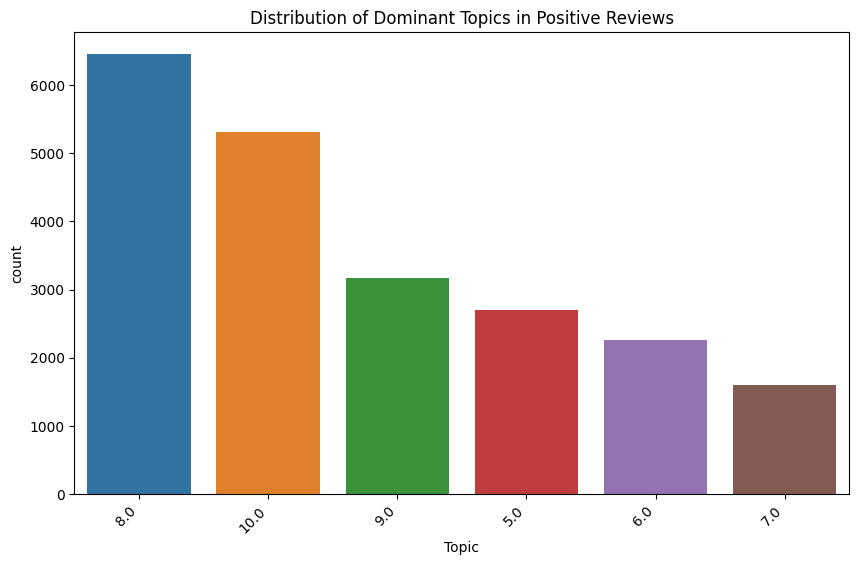

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of dominant topics
plt.figure(figsize=(10, 6))
sns.countplot(x='Topic', data=new_df, order=new_df['Topic'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Dominant Topics in Positive Reviews')
plt.show()



In [ ]:
# concatenating final data sets of positive and negative topics into one dataframe
fin_df = pd.concat([new_df,new_neg_df], axis=0)

In [ ]:
fin_df.reset_index(inplace=True)

In [ ]:
fin_df.drop(columns=['index','level_0'],inplace=True)

In [ ]:
fin_df.head()

,review,new_sentiments,polarity,accuracy,Topic
0,love phone,Positive,0.5,0.090909,8.0
1,love phone,Positive,0.5,0.090909,8.0
2,worth paying something else,Positive,0.3,0.076923,8.0
3,love,Positive,0.5,0.100000,8.0
4,excellent product,Positive,1.0,0.090909,8.0


Using the above Topic Identified Data for Machine Learning Model that can be directly used other kind of products in future.


In [ ]:
# Dividing dataset into features and target vectors

X = fin_df['review']
y = fin_df['Topic']

Running various Classifier ML Models and choosing the best one.

In [ ]:
# Naive Bayes Model

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data to numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=500)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Create a Multinomial Naive Bayes classifier
model_nb = MultinomialNB()

# Train the model
model_nb.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = model_nb.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')


Accuracy: 0.8273226185809487
Confusion Matrix:
[[ 113    0    0   14    1    0    0    3   13   11   26]
 [   0   35    0   12    0    7    9    7    7    1   18]
 [   4    0   74    1    1    0    1    0   13    0   50]
 [   4    0    1  145    4    1    0    4    1    0   89]
 [   1    0    1    7   72    1    0    1    6    1   57]
 [   0    2    0    0    1  467    0    0   13    1   56]
 [   0    0    0    0    0    5  381    2   18    0   23]
 [   1    0    0    4    0    4    1  140   36    0  133]
 [   0    0    0    3    5    6    3    4 1208    0   75]
 [   3    0    1    1    1    3    0    1    1  584   72]
 [   1    0    6    1    3    1    2    2    6    2 1002]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.62      0.73       181
         1.0       0.95      0.36      0.53        96
         2.0       0.89      0.51      0.65       144
         3.0       0.77      0.58      0.66       249
         4.0       0

In [ ]:
# Gradient Boosting Classifier

from sklearn.ensemble import GradientBoostingClassifier
model_gb = GradientBoostingClassifier()
model_gb.fit(X_train_tfidf, y_train)
y_pred_gb = model_gb.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_gb)
conf_matrix = confusion_matrix(y_test, y_pred_gb)
classification_rep = classification_report(y_test, y_pred_gb)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.9284594276754214
Confusion Matrix:
[[ 135    0    0    0    0    0    1   12   19   11    3]
 [   4   60    0    0    0    5   11   11    1    1    3]
 [   3    0   96    0    0    0    0    1   12    1   31]
 [   4    0    3  177    0    0    1   13    3    5   43]
 [   2    0    1    2  103    0    1    2    0    1   35]
 [   0    5    0    0    0  529    0    0    0    0    6]
 [   0    1    0    0    0    2  425    0    0    0    1]
 [   1    2    0    3    5    5    5  292    0    0    6]
 [   1    0    0    1    9    2    3    6 1276    0    6]
 [   2    0    1    0    1    0    0    1    2  660    0]
 [   1    0    3   10    9    1    3    3    7    5  984]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.75      0.81       181
         1.0       0.88      0.62      0.73        96
         2.0       0.92      0.67      0.77       144
         3.0       0.92      0.71      0.80       249
         4.0       0

In [ ]:
# Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_tfidf, y_train)
y_pred_rf = model_rf.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
conf_matrix = confusion_matrix(y_test, y_pred_rf)
classification_rep = classification_report(y_test, y_pred_rf)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.9370834966679733
Confusion Matrix:
[[ 145    0    0    0    0    0    0   12   12    9    3]
 [   2   58    0    1    1    6   11   13    2    1    1]
 [   4    0   99    0    0    0    0    2   13    1   25]
 [   4    1    2  181    0    2    1   10    2    1   45]
 [   2    0    0    8   92    0    1    2    2    1   39]
 [   1    5    0    0    0  534    0    0    0    0    0]
 [   0    0    0    0    0    1  428    0    0    0    0]
 [   1    0    0    5    2    2    1  306    0    0    2]
 [   1    0    0    2    4    3    0   10 1281    0    3]
 [   1    1    0    0    1    0    0    2    0  662    0]
 [   0    0    6    6    5    2    4    1    4    3  995]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.80      0.85       181
         1.0       0.89      0.60      0.72        96
         2.0       0.93      0.69      0.79       144
         3.0       0.89      0.73      0.80       249
         4.0       0

In [ ]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression()
model_lr.fit(X_train_tfidf, y_train)
y_pred_lr = model_lr.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_lr)
conf_matrix = confusion_matrix(y_test, y_pred_lr)
classification_rep = classification_report(y_test, y_pred_lr)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.9310074480595845
Confusion Matrix:
[[ 145    0    0    1    1    1    0    8   11   12    2]
 [   1   60    0    4    0    3   11   14    1    1    1]
 [   6    1  100    0    0    0    0    1   12    1   23]
 [   5    1    1  189    0    1    0   10    0    2   40]
 [   1    0    1   10  106    2    0    4    1    1   21]
 [   0    5    0    0    0  533    0    1    0    0    1]
 [   0    0    0    0    0    3  424    0    0    0    2]
 [   0    1    0    5    1    5    2  290    0    0   15]
 [   3    1    0    1    2    6    3    8 1272    0    8]
 [   3    0    0    0    1    1    0    4    2  654    2]
 [   1    0    8   16    3    1    1    5    9    5  977]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.80      0.84       181
         1.0       0.87      0.62      0.73        96
         2.0       0.91      0.69      0.79       144
         3.0       0.84      0.76      0.80       249
         4.0       0

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# SVM - Support Vector Machine

from sklearn.svm import SVC
model_svm = SVC()
model_svm.fit(X_train_tfidf, y_train)
y_pred_svm = model_svm.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_svm)
conf_matrix = confusion_matrix(y_test, y_pred_svm)
classification_rep = classification_report(y_test, y_pred_svm)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.9362994903959232
Confusion Matrix:
[[ 149    0    0    0    1    0    0   11    9    9    2]
 [   1   62    0    3    1    3    9   14    1    0    2]
 [   7    2   96    0    0    0    1    1   12    1   24]
 [   5    1    2  189    0    1    0   13    1    1   36]
 [   1    0    1    9   96    1    1    1    1    1   35]
 [   0    8    0    0    0  530    0    0    1    0    1]
 [   0    0    0    0    1    1  426    1    0    0    0]
 [   0    0    0    6    1    1    0  307    0    0    4]
 [   1    0    0    1    5    4    2   11 1275    0    5]
 [   2    0    0    0    1    0    1    5    0  657    1]
 [   1    1    7    6    4    2    2    7    4    2  990]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.82      0.86       181
         1.0       0.84      0.65      0.73        96
         2.0       0.91      0.67      0.77       144
         3.0       0.88      0.76      0.82       249
         4.0       0

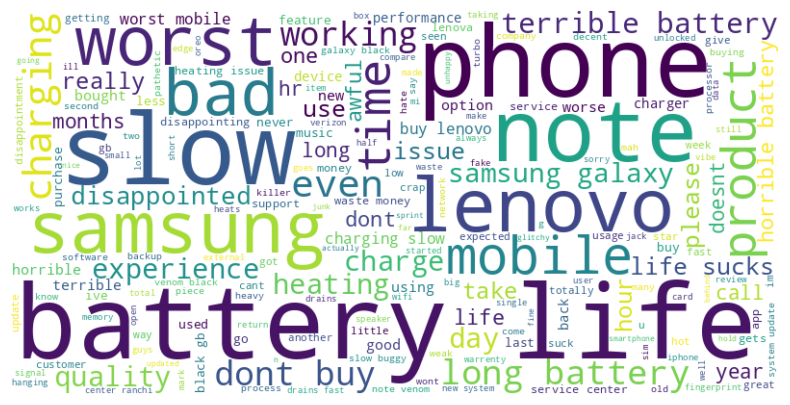

In [ ]:
# Visualizing Topics

import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create dataframe for a particular topic id
my_df = fin_df[fin_df['Topic']==1]

# Concatenate all text data into a single string
text_data = ' '.join(my_df['review'].astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


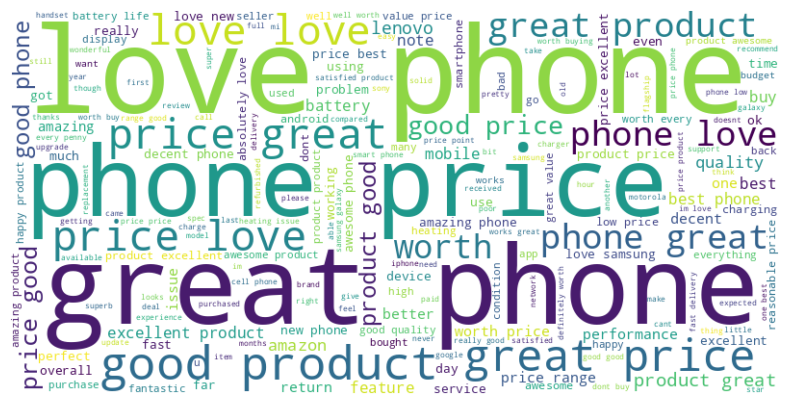

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create dataframe for a particular topic id
my_df = fin_df[fin_df['Topic']==8]

# Concatenate all text data into a single string
text_data = ' '.join(my_df['review'].astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
